In [1]:
# Install necessary packages
!pip install kagglehub --upgrade -q


In [2]:
import kagglehub

# Download dataset using kagglehub
path = kagglehub.dataset_download("roudranildas/chicken-images-classification-dataset")
print("Dataset downloaded to:", path)


Dataset downloaded to: /kaggle/input/chicken-images-classification-dataset


In [3]:
import os

for root, dirs, files in os.walk(path):
    print(root)


/kaggle/input/chicken-images-classification-dataset
/kaggle/input/chicken-images-classification-dataset/data
/kaggle/input/chicken-images-classification-dataset/data/duck-images
/kaggle/input/chicken-images-classification-dataset/data/duck-images/data
/kaggle/input/chicken-images-classification-dataset/data/duck-images/data/val
/kaggle/input/chicken-images-classification-dataset/data/duck-images/data/test
/kaggle/input/chicken-images-classification-dataset/data/duck-images/data/train
/kaggle/input/chicken-images-classification-dataset/data/chicken-images
/kaggle/input/chicken-images-classification-dataset/data/chicken-images/data
/kaggle/input/chicken-images-classification-dataset/data/chicken-images/data/val
/kaggle/input/chicken-images-classification-dataset/data/chicken-images/data/test
/kaggle/input/chicken-images-classification-dataset/data/chicken-images/data/train


In [4]:
import os
import shutil

# Function to prepare dataset folders compatible with ImageFolder
def prepare_folder(split):
    for bird in ["chicken", "duck"]:
        src = os.path.join(path, "data", f"{bird}-images", "data", split)
        dst = f"merged_data/{split}/{bird}"
        os.makedirs(dst, exist_ok=True)

        for fname in os.listdir(src):
            shutil.copy(os.path.join(src, fname), os.path.join(dst, fname))

# Organize into train, val, and test folders
for split in ["train", "val", "test"]:
    prepare_folder(split)


In [5]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets
train_ds = ImageFolder("merged_data/train", transform=transform_train)
val_ds   = ImageFolder("merged_data/val", transform=transform_eval)
test_ds  = ImageFolder("merged_data/test", transform=transform_eval)

# Data loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)
test_loader  = DataLoader(test_ds, batch_size=16)

class_names = train_ds.classes
print("Classes:", class_names)


Classes: ['chicken', 'duck']


In [6]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze feature extractor layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)  # Two output classes
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Train loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for images, labels in progress:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress.set_postfix(loss=total_loss / len(train_loader))

    print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")


Epoch 1: 100%|██████████| 57/57 [01:35<00:00,  1.67s/it, loss=0.39]


Epoch 1 - Loss: 0.3897


Epoch 2: 100%|██████████| 57/57 [01:32<00:00,  1.63s/it, loss=0.248]


Epoch 2 - Loss: 0.2483


Epoch 3: 100%|██████████| 57/57 [01:32<00:00,  1.62s/it, loss=0.226]


Epoch 3 - Loss: 0.2257


Epoch 4: 100%|██████████| 57/57 [01:32<00:00,  1.62s/it, loss=0.213]


Epoch 4 - Loss: 0.2129


Epoch 5: 100%|██████████| 57/57 [01:37<00:00,  1.72s/it, loss=0.209]


Epoch 5 - Loss: 0.2087


Epoch 6: 100%|██████████| 57/57 [01:33<00:00,  1.65s/it, loss=0.213]


Epoch 6 - Loss: 0.2132


Epoch 7: 100%|██████████| 57/57 [01:33<00:00,  1.64s/it, loss=0.219]


Epoch 7 - Loss: 0.2193


Epoch 8: 100%|██████████| 57/57 [01:33<00:00,  1.64s/it, loss=0.273]


Epoch 8 - Loss: 0.2733


Epoch 9: 100%|██████████| 57/57 [01:33<00:00,  1.63s/it, loss=0.209]


Epoch 9 - Loss: 0.2087


Epoch 10: 100%|██████████| 57/57 [01:32<00:00,  1.63s/it, loss=0.235]

Epoch 10 - Loss: 0.2351


Classification Report:
              precision    recall  f1-score   support

     chicken       0.97      0.92      0.95       172
        duck       0.96      0.98      0.97       310

    accuracy                           0.96       482
   macro avg       0.96      0.95      0.96       482
weighted avg       0.96      0.96      0.96       482



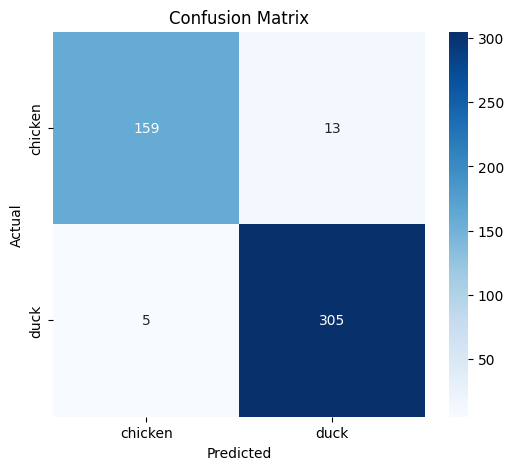

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_true, y_pred = [], []

# Gather predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


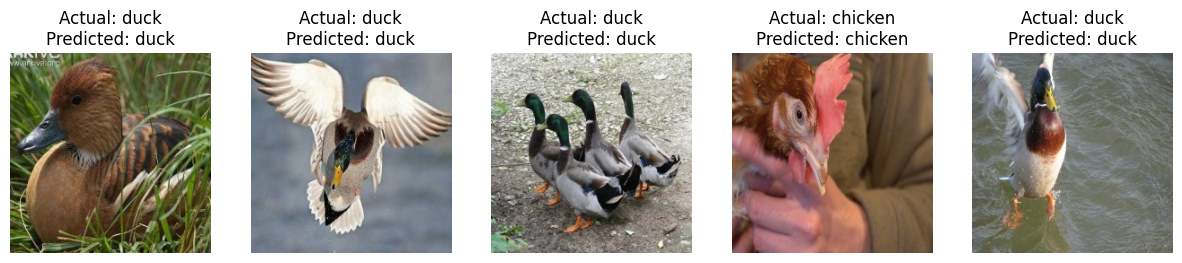

In [9]:
import random

# Get sample predictions
sample_images, sample_labels, sample_preds = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        sample_images.extend(images.cpu())
        sample_labels.extend(labels.numpy())
        sample_preds.extend(preds.cpu().numpy())

# Show 5 random predictions
indices = random.sample(range(len(sample_images)), 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(indices):
    image = sample_images[idx].permute(1, 2, 0).numpy()
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = np.clip(image, 0, 1)

    actual = class_names[sample_labels[idx]]
    predicted = class_names[sample_preds[idx]]

    axes[i].imshow(image)
    axes[i].set_title(f"Actual: {actual}\nPredicted: {predicted}")
    axes[i].axis("off")

plt.show()
